# Model Robustness Analysis: Similarity vs. Input Errors

This notebook provides a detailed analysis of how the similarity scores of various language models change as the number of input errors increases.

The analysis includes:
- Descriptive statistics across models and error counts.
- Visualization of similarity score distributions.
- Trend analysis of robustness degradation.
- Correlation analysis between model size and robustness.

All plots are designed for clarity and reproducibility in scientific publications.


In [47]:
# Environment Setup
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# Plotting style
sns.set_context("talk", font_scale=1.5)   # Font size globally
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelsize'] = 20        # Axis label font size
plt.rcParams['axes.titlesize'] = 26        # Title font size
plt.rcParams['xtick.labelsize'] = 18       # X tick labels
plt.rcParams['ytick.labelsize'] = 18       # Y tick labels
plt.rcParams['legend.fontsize'] = 16       # Legend font size


# Load Data
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
json_path = os.path.join(project_root, "evaluation", "similarity_vector_results.json")

with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

records = []
for item in data:
    model = item["model"]
    model_size = int(item["model_size"])
    error_count = int(item["error_count"])
    similarities = item["similarities"]

    for sim in similarities:
        records.append({
            "model": model,
            "model_size": model_size,
            "error_count": error_count,
            "similarity": sim
        })

df = pd.DataFrame(records)


# 1. Descriptive Statistics

We first summarize the distribution of similarity scores across models and error counts.


In [48]:
# Adjust Pandas display settings to show more rows
pd.set_option('display.max_rows', 150)

# Compute Summary Statistics
summary_stats = df.groupby(["model", "error_count"]).agg(
    mean_similarity=("similarity", "mean"),
    std_similarity=("similarity", "std"),
    median_similarity=("similarity", "median"),
    p25_similarity=("similarity", lambda x: np.percentile(x, 25)),
    p75_similarity=("similarity", lambda x: np.percentile(x, 75)),
    count=("similarity", "count")
).reset_index()

# Display the first 50 rows as an example
summary_stats.head(150)


,model,error_count,mean_similarity,std_similarity,median_similarity,p25_similarity,p75_similarity,count
0,eleutherai/gpt-neo-125m,1,77.832067,15.791526,78.140,64.0200,92.1450,2250
1,eleutherai/gpt-neo-125m,2,74.029569,14.998809,72.865,61.2250,86.2800,2250
2,eleutherai/gpt-neo-125m,3,72.701424,14.896946,72.860,59.0900,83.7200,2205
3,eleutherai/gpt-neo-125m,4,70.765130,13.173313,69.460,59.6650,79.7900,2115
4,eleutherai/gpt-neo-125m,5,68.811854,12.763773,66.600,58.4775,77.5375,1980
5,eleutherai/gpt-neo-125m,6,69.598396,13.402841,67.150,58.7000,78.7000,1845
6,eleutherai/gpt-neo-125m,7,68.109778,13.411646,65.290,57.2800,77.5000,1845
7,eleutherai/gpt-neo-125m,8,67.432870,12.361530,64.645,57.5500,75.7600,1620
8,eleutherai/gpt-neo-125m,9,66.276420,12.294063,62.980,56.8000,73.4550,1620
9,eleutherai/gpt-neo-125m,10,66.597410,12.711225,63.340,56.8975,74.1725,1440


# 2. Distribution of Similarity Scores

We examine the overall distribution of similarity scores across all models and all error counts.


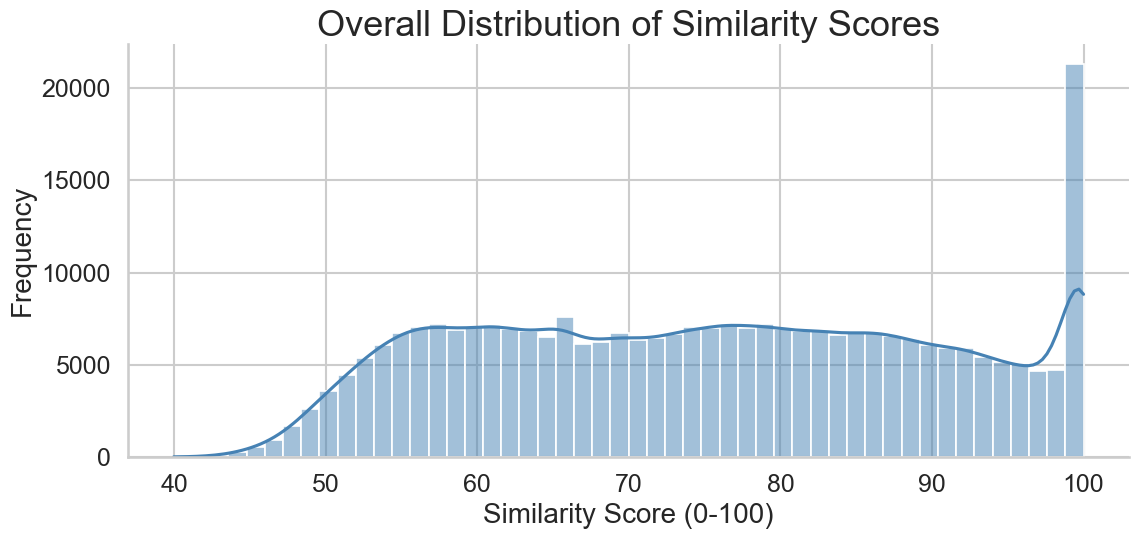

In [49]:
# Overall Distribution
plt.figure(figsize=(12, 6))
sns.histplot(df["similarity"], bins=50, kde=True, color="steelblue")
plt.title("Overall Distribution of Similarity Scores")
plt.xlabel("Similarity Score (0-100)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


# 3. Distribution by Error Count (Aggregated Over All Models)

This plot shows the distribution of similarity scores across different error counts, **aggregated over all models**.

Each box represents the spread (25th percentile to 75th percentile) of similarity scores for a specific number of input errors, considering all models together.

No distinction between models is made in this visualization — it captures the general trend across all models.


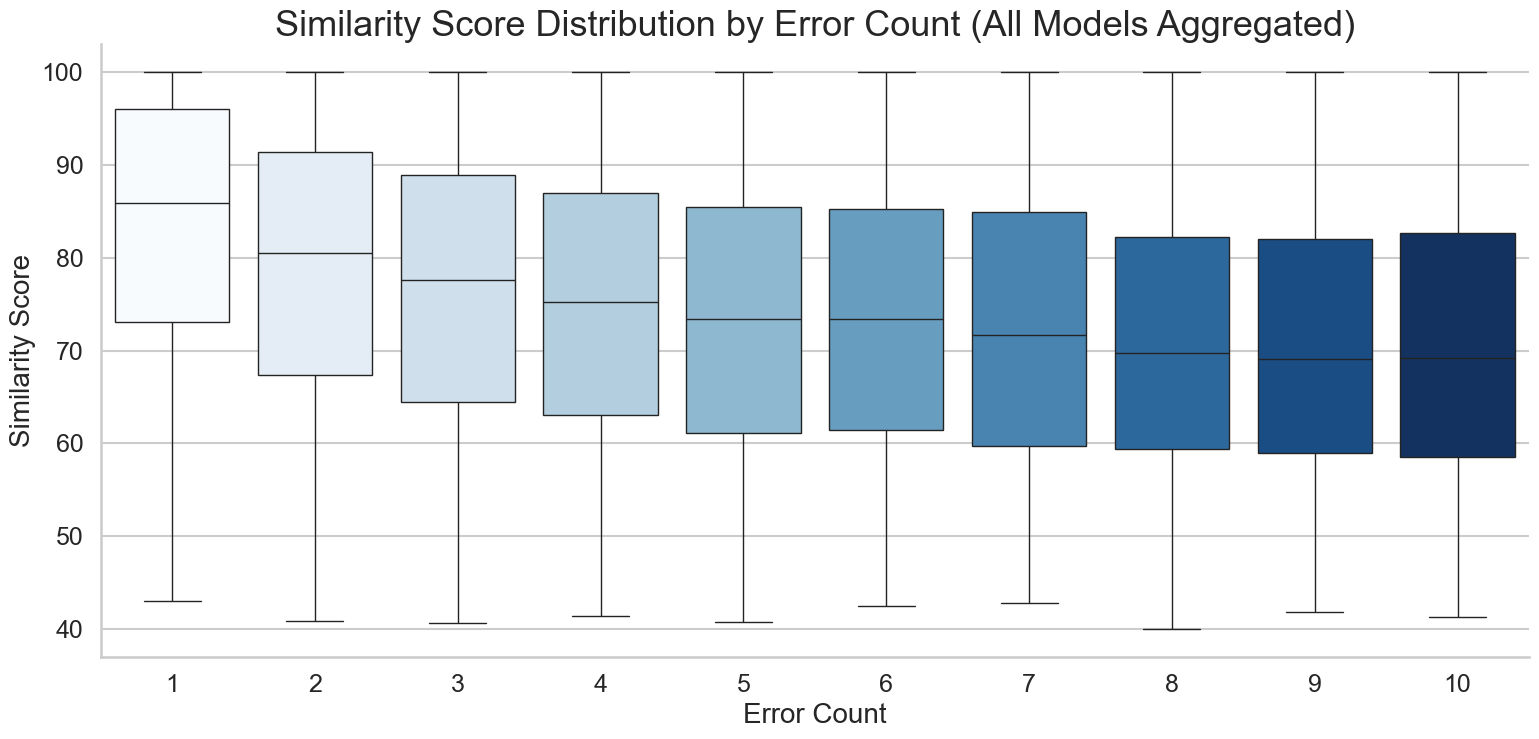

In [50]:
# Boxplot per Error Count (Aggregated Over All Models, Beautiful Colors, No Warning)

plt.figure(figsize=(16, 8))
sns.boxplot(
    x="error_count",
    y="similarity",
    hue="error_count",          # Add hue = error_count
    data=df,
    palette="Blues",             # Use a clean, scientific palette
    dodge=False                  # Prevent side-by-side split
)
plt.title("Similarity Score Distribution by Error Count (All Models Aggregated)")
plt.xlabel("Error Count")
plt.ylabel("Similarity Score")
plt.legend([],[], frameon=False)  # Remove the legend
plt.tight_layout()
plt.show()


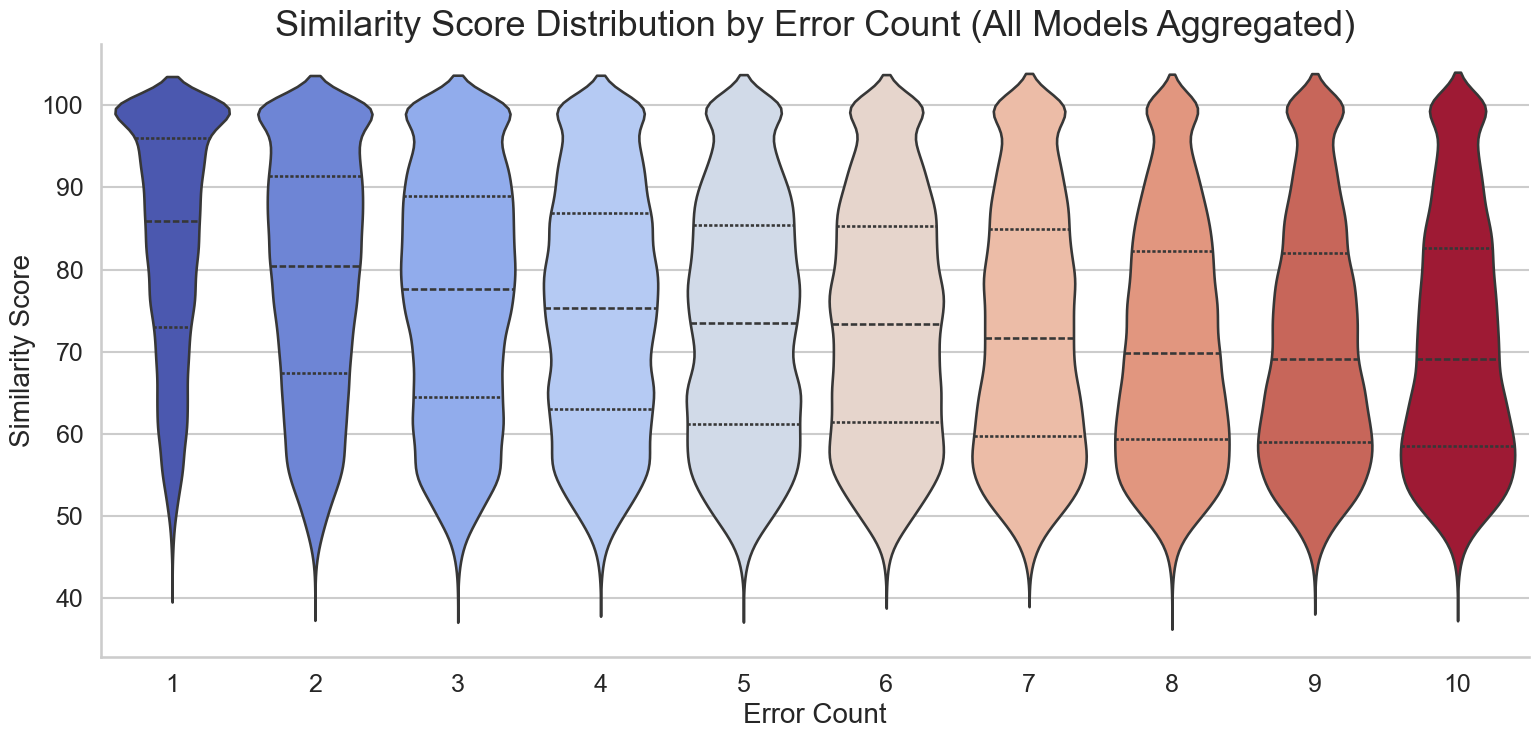

In [51]:
# Violin Plot per Error Count (Aggregated Over All Models, Beautiful Colors, No Warning)

plt.figure(figsize=(16, 8))
sns.violinplot(
    x="error_count",
    y="similarity",
    hue="error_count",             # Assign hue to match palette
    data=df,
    inner="quartile",              # Show median and interquartile range
    palette="coolwarm",            # Nice gradient palette
    dodge=False                    # Prevent side-by-side split
)
plt.title("Similarity Score Distribution by Error Count (All Models Aggregated)")
plt.xlabel("Error Count")
plt.ylabel("Similarity Score")
plt.legend([], [], frameon=False)  # Remove the legend
plt.tight_layout()
plt.show()


# 4. Model Performance Across Error Counts

We now analyze each model individually to see how its similarity score changes with increasing errors.


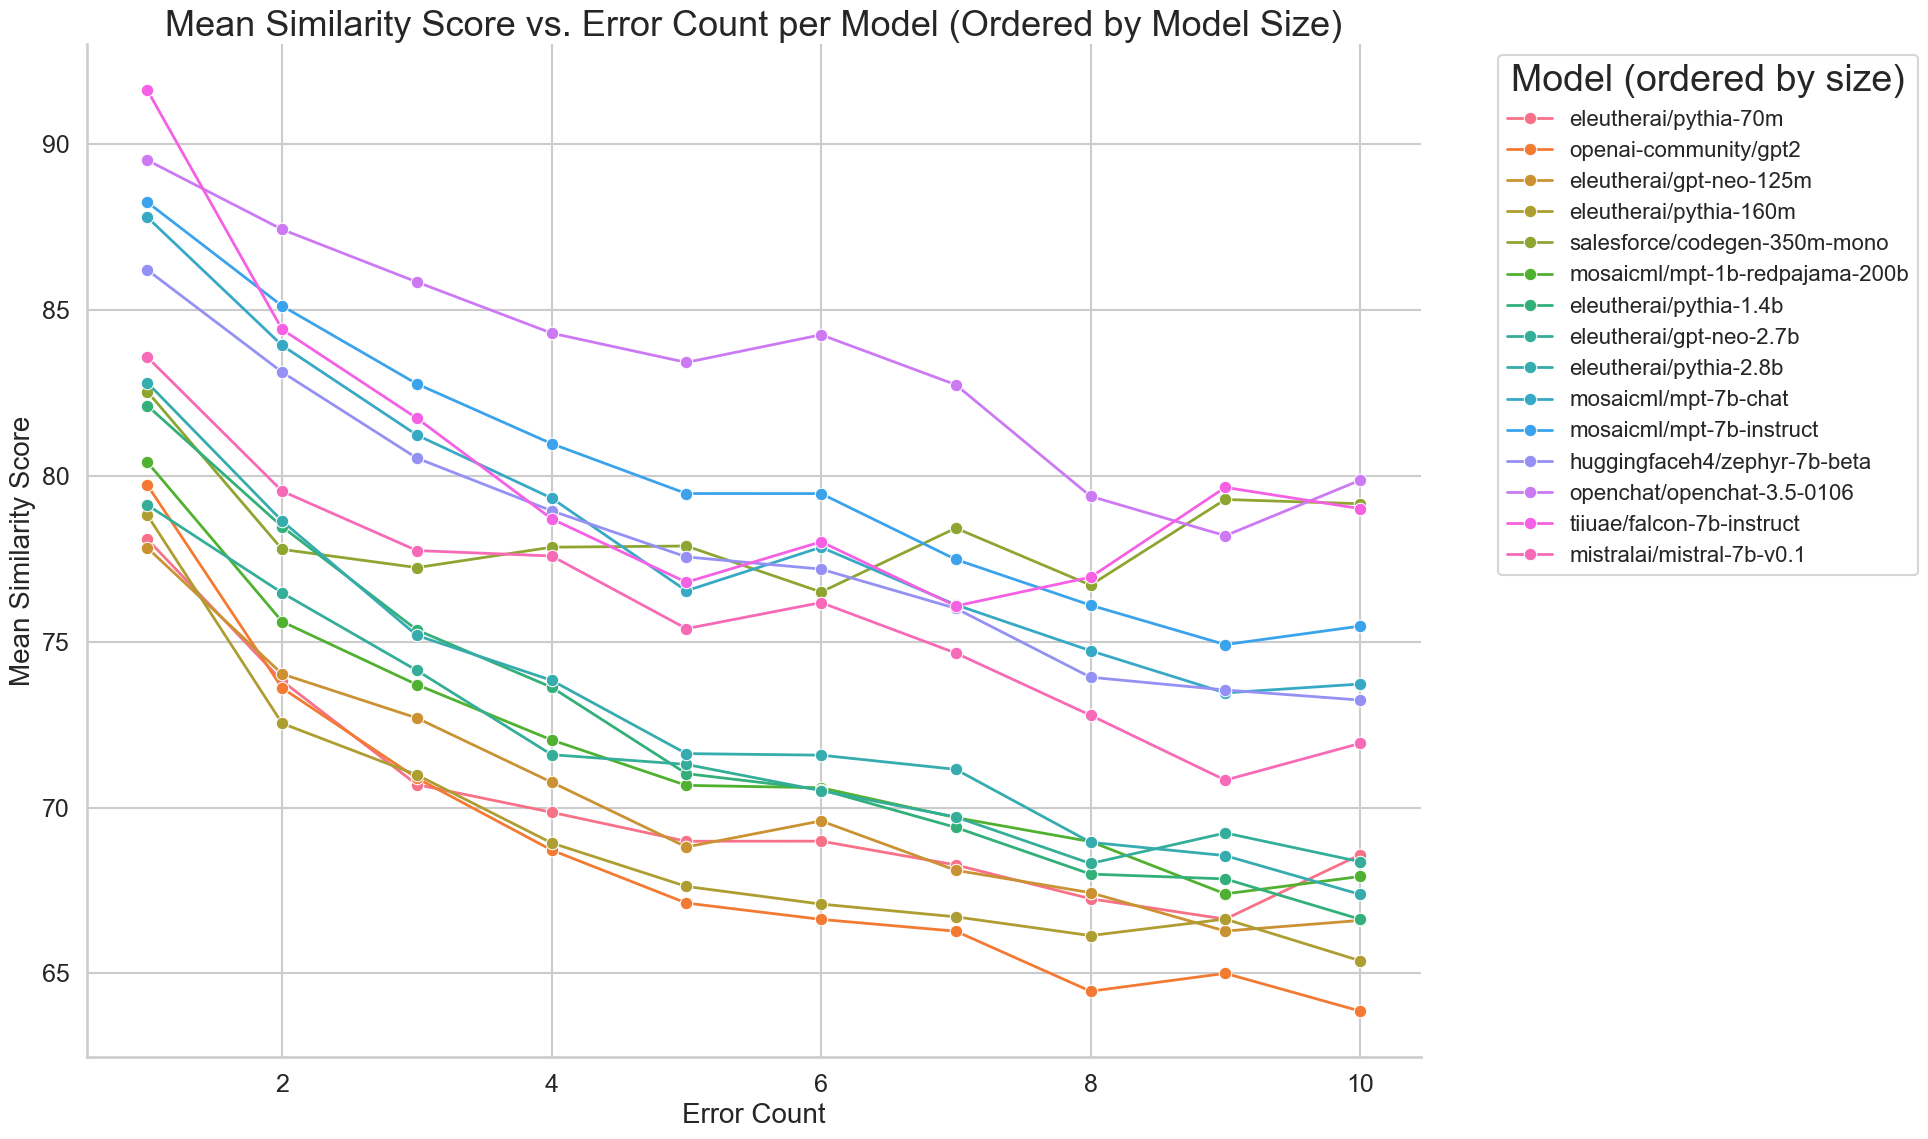

In [52]:
# Prepare model order by model size (Correct Way)
model_order = (df.groupby(["model", "model_size"])
               .size()
               .reset_index()
               .sort_values("model_size")["model"]
               .tolist())

# Lineplot: Mean Similarity per Model (Ordered by Model Size)
plt.figure(figsize=(20, 12))
sns.lineplot(
    data=summary_stats,
    x="error_count",
    y="mean_similarity",
    hue="model",
    hue_order=model_order,        # <-- Order models by size
    marker="o",
    linewidth=2
)
plt.title("Mean Similarity Score vs. Error Count per Model (Ordered by Model Size)")
plt.xlabel("Error Count")
plt.ylabel("Mean Similarity Score")
plt.legend(
    title="Model (ordered by size)",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    ncol=1,
    frameon=True
)
plt.tight_layout()
plt.show()


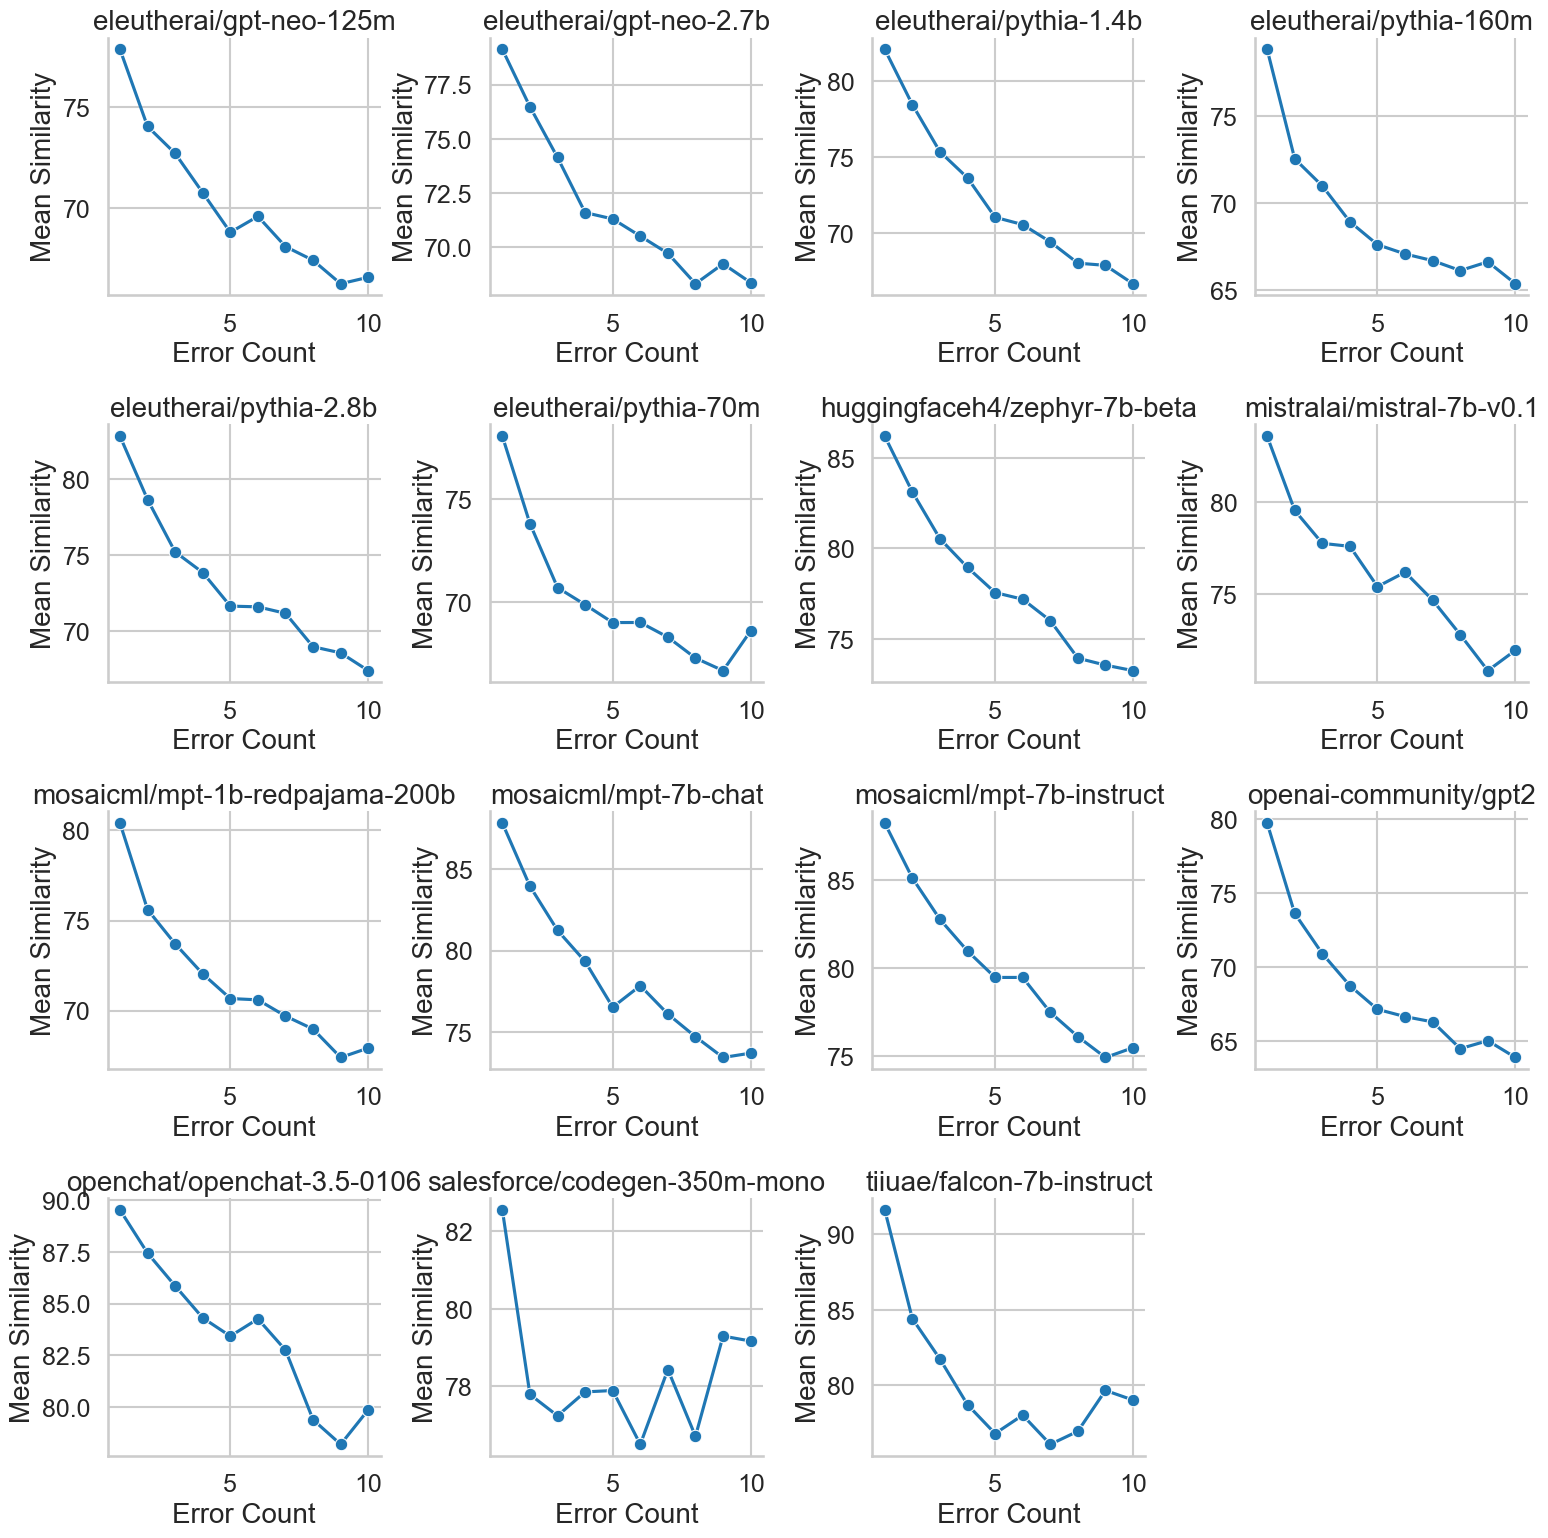

In [53]:
# Faceted Grid: One Plot per Model (With Axis Labels on Every Subplot)

g = sns.FacetGrid(
    summary_stats,
    col="model",
    col_wrap=4,
    height=4,
    sharex=False,          # <-- DO NOT share x-axis
    sharey=False           # <-- DO NOT share y-axis
)
g.map_dataframe(sns.lineplot, x="error_count", y="mean_similarity", marker="o")

# Set axis labels individually
for ax in g.axes.flatten():
    ax.set_xlabel("Error Count")
    ax.set_ylabel("Mean Similarity")

g.set_titles(col_template="{col_name}")

# More space between plots
g.fig.subplots_adjust(hspace=0.5, wspace=0.4)

plt.show()

# 5. Robustness Degradation Analysis

We investigate the rate of performance drop per model.


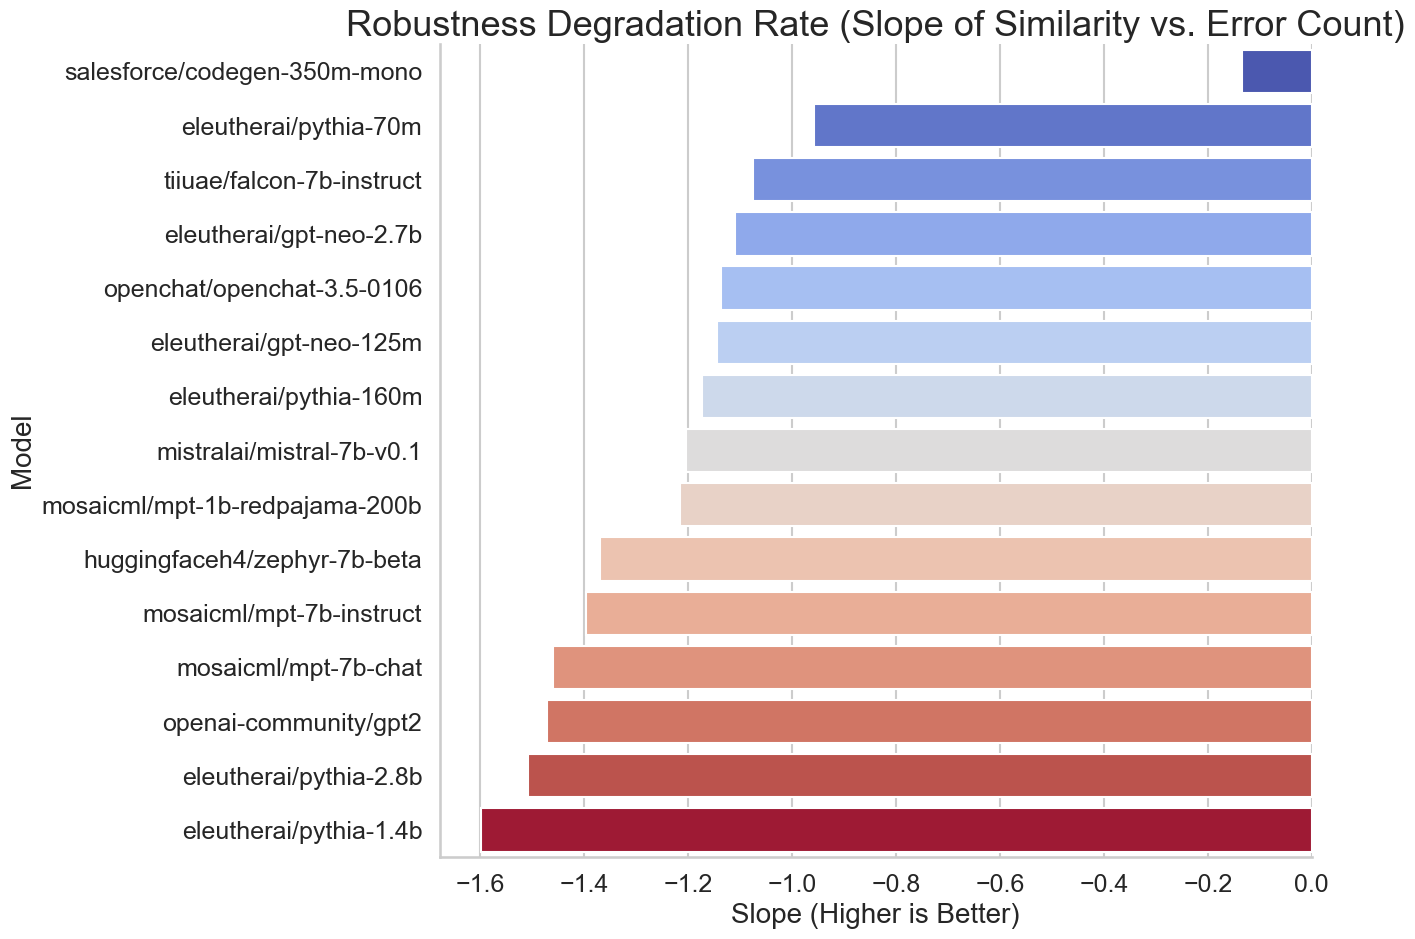

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Calculate Degradation Rate (Slope) — No Warnings
degradation = summary_stats.groupby("model").apply(
    lambda x: np.polyfit(x["error_count"], x["mean_similarity"], 1)[0],
    include_groups=False
).reset_index(name="slope")

# Sort models by slope (higher slope = more robust)
degradation_sorted = degradation.sort_values("slope", ascending=False)

# Prepare colors from coolwarm
n_models = degradation_sorted.shape[0]
cmap = mpl.cm.coolwarm
colors = [cmap(i / (n_models - 1)) for i in range(n_models)]  # Evenly spaced colors
palette = dict(zip(degradation_sorted["model"], colors))

# Barplot: Degradation Rates — No Warnings, Clean Colors
plt.figure(figsize=(14, 10))
sns.barplot(
    data=degradation_sorted,
    y="model",
    x="slope",
    hue="model",                 # Add hue to avoid Seaborn warning
    palette=palette,              # Custom palette
    dodge=False                   # Don't split bars
)
plt.title("Robustness Degradation Rate (Slope of Similarity vs. Error Count)")
plt.xlabel("Slope (Higher is Better)")
plt.ylabel("Model")
plt.legend([], [], frameon=False)  # Remove legend to avoid clutter
plt.tight_layout()
plt.show()


# 6. Correlation Between Model Size and Robustness

We test whether model size is correlated with robustness.


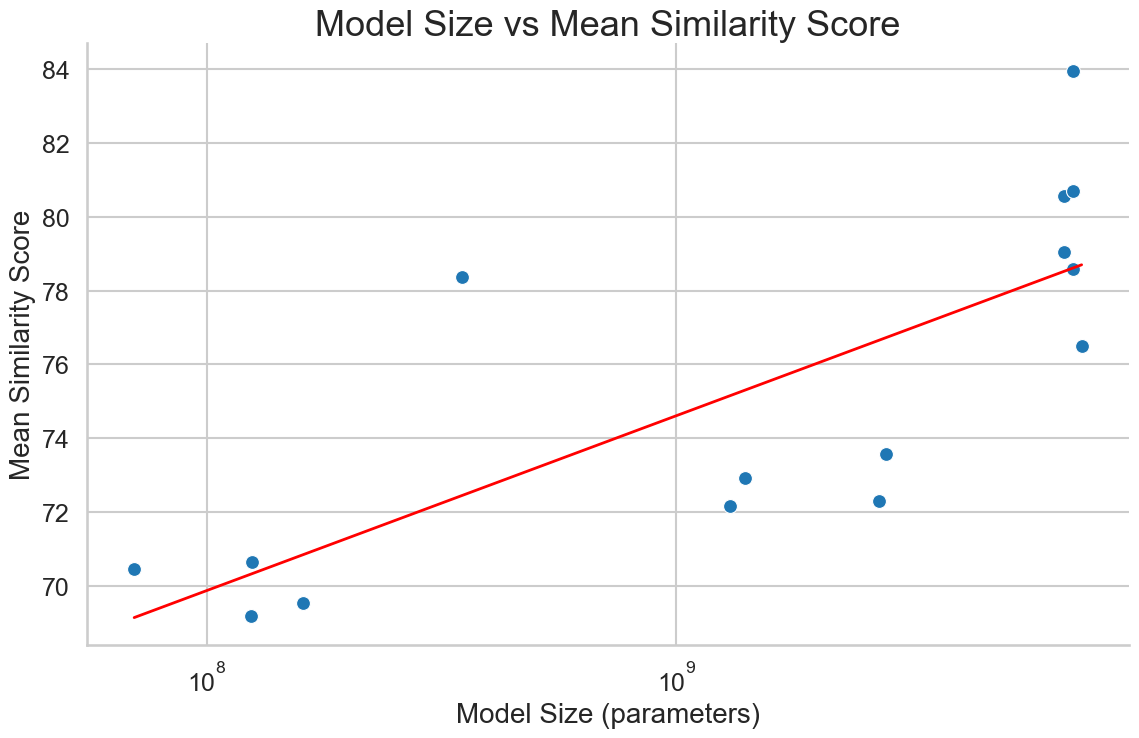

Pearson correlation: 0.832 (p-value: 0.00012)
Spearman correlation: 0.831 (p-value: 0.000126)


In [57]:
# Correlation Analysis (Without Confidence Interval)

# Summarize model size and mean similarity
model_size_summary = df.groupby(["model", "model_size"]).agg(
    mean_similarity=("similarity", "mean")
).reset_index()

plt.figure(figsize=(12, 8))

# Scatter plot
sns.scatterplot(
    data=model_size_summary,
    x="model_size",
    y="mean_similarity",
    s=100
)

# Regression line without confidence interval
sns.regplot(
    data=model_size_summary,
    x="model_size",
    y="mean_similarity",
    scatter=False,
    logx=True,
    ci=None,                         # <-- REMOVE shaded area
    line_kws={"color": "red", "linewidth": 2}
)

plt.title("Model Size vs Mean Similarity Score")
plt.xlabel("Model Size (parameters)")
plt.ylabel("Mean Similarity Score")
plt.xscale("log")
plt.grid(True)
plt.tight_layout()
plt.show()

# Pearson and Spearman Correlation
pearson_corr, pearson_p = pearsonr(model_size_summary["model_size"], model_size_summary["mean_similarity"])
spearman_corr, spearman_p = spearmanr(model_size_summary["model_size"], model_size_summary["mean_similarity"])

print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3g})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3g})")


# 7. Distribution per Model (Ordered by Model Size)

A focused view of the distribution of similarity scores per model, aggregated over all error counts.

The models are ordered by **model size** (number of parameters) for better interpretability.


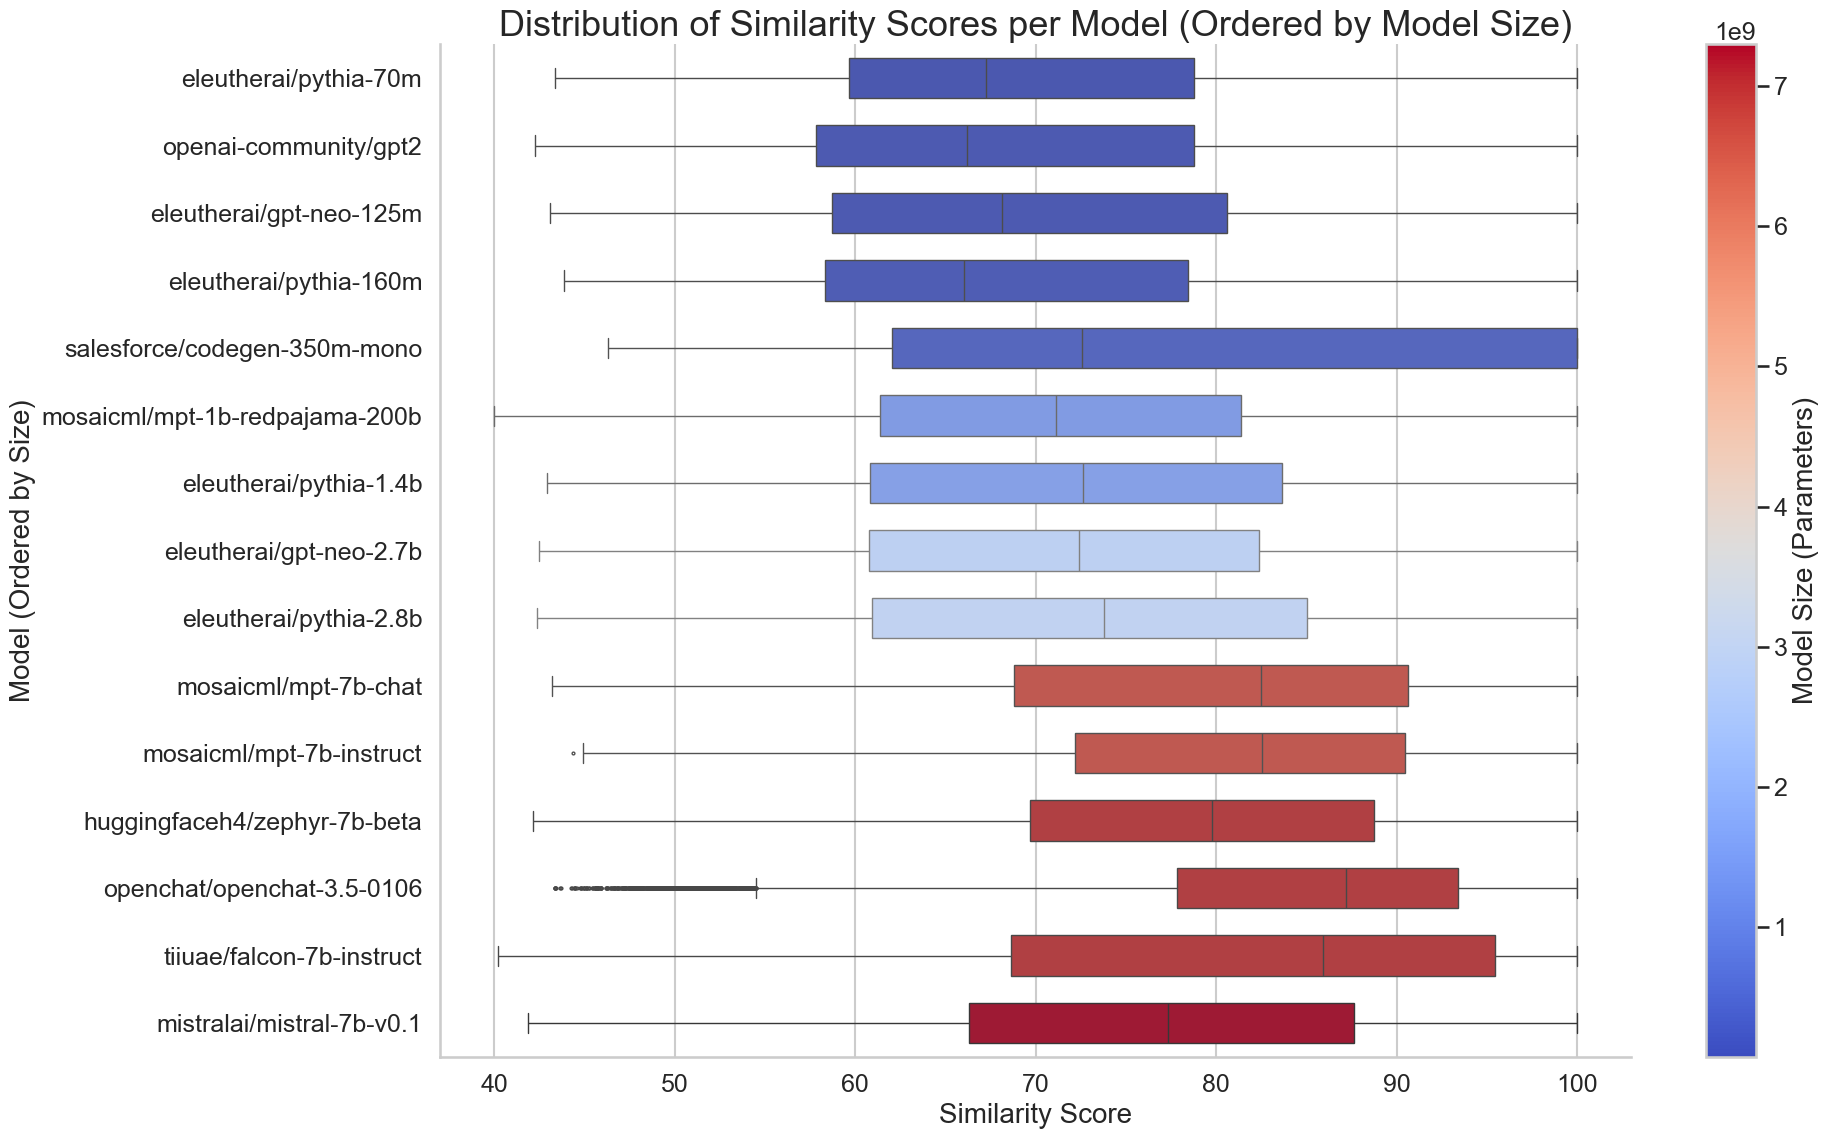

In [63]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare order by model size
model_info = df.groupby("model")["model_size"].first().sort_values()
model_order = model_info.index.tolist()

# Normalize model sizes for colormap
norm = mpl.colors.Normalize(vmin=model_info.min(), vmax=model_info.max())
cmap = mpl.cm.coolwarm  # Changed to coolwarm

# Map model_size to colors
colors = [cmap(norm(size)) for size in model_info.values]

# Create figure and axis
fig, ax = plt.subplots(figsize=(20, 12))

# Boxplot: plot each model separately with its color
for i, model in enumerate(model_order):
    sns.boxplot(
        data=df[df["model"] == model],
        x="similarity",
        y="model",
        orient="h",
        color=colors[i],
        width=0.6,
        fliersize=2,
        ax=ax
    )

ax.set_title("Distribution of Similarity Scores per Model (Ordered by Model Size)")
ax.set_xlabel("Similarity Score")
ax.set_ylabel("Model (Ordered by Size)")

# Create colorbar linked to the colormap
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Dummy array for colorbar
cbar = fig.colorbar(sm, ax=ax, orientation="vertical")
cbar.set_label("Model Size (Parameters)")

plt.tight_layout()
plt.show()
